## What is in the notebook:

This notebook gathers together state maternal mortality data, health-insurance data, and income data for states between 2010-2019. It also gathers together various natility data from 2010-2019.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import copy

### Loading Data

#### CDC Maternal mortality data

In [2]:
maternal_mortality_df = pd.read_csv("..\\data\\cdc_data\\all_states_all_codes_by_year.csv")
maternal_mortality_df = maternal_mortality_df[["State", "Year", "Deaths", "Population"]]
print(maternal_mortality_df[maternal_mortality_df.Year>=1995])



              State  Year  Deaths  Population
0           Alabama  1999      10     1801848
1           Alabama  2005      12     1856905
2           Alabama  2006      10     1880993
3           Alabama  2015      12     1929191
4           Alabama  2016      35     1920571
...             ...   ...     ...         ...
1197        Vermont  1995       0      300279
1198        Vermont  1996       0      303034
1199        Vermont  1997       0      304893
1220     Washington  1995       0     2757505
1231  West Virginia  1995       0      941762

[631 rows x 4 columns]


#### ACS Income Data

This data frame needs to be pivoted.

In [3]:
income_df = pd.read_csv("..\\data\\acs_income_by_year\\all_income_from_2010_to_2023.csv")
income_df = income_df[income_df.columns[1:]]
income_df_pivot = pd.pivot(data = income_df,  index ='Year', columns= 'label')
income_df = income_df_pivot.stack(level=0)
income_df.reset_index(inplace=True)
income_df.rename(columns = {"level_1" : "State"},inplace= True)
income_df.head()




C:\Users\david\AppData\Local\Temp\ipykernel_18840\560642248.py:4: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  income_df = income_df_pivot.stack(level=0)


label,Year,State,"$10,000 to $14,999","$100,000 to $149,999","$15,000 to $24,999","$150,000 to $199,999","$200,000 or more","$25,000 to $34,999","$35,000 to $49,999","$50,000 to $74,999","$75,000 to $99,999","Less than $10,000",Total
0,2010,Alabama,291136,462295,568262,155190,110550,515050,683128,805464,487371,418610,4499250
1,2010,Alaska,24791,122561,46620,45879,36225,52474,73631,121399,89373,23792,637189
2,2010,Arizona,301174,694479,620656,213517,196895,663570,884336,1119302,695469,414482,5802329
3,2010,Arkansas,186755,243784,379359,68553,56348,371449,442926,508686,289906,236611,2784750
4,2010,California,1486323,4692266,2969203,2048096,2047855,2756878,3942244,5360641,3913537,1690857,30895516


Here we aggregate the income data. Change the boolean ```Agg_Income``` to ```False``` if you do not want to aggregate income.

In [4]:
Agg_Income = False
if Agg_Income:
    income_df['sub_75k_income'] = income_df["Less than $10,000"]+income_df["$10,000 to $14,999"]+income_df["$15,000 to $24,999"]+income_df["$25,000 to $34,999"]+income_df["$35,000 to $49,999"]+income_df["$50,000 to $74,999"]
    income_df['between_75k_150k_income'] = income_df['$75,000 to $99,999']+income_df["$100,000 to $149,999"]
    income_df['above_150k_income'] = income_df['$150,000 to $199,999']+income_df['$200,000 or more']
    income_df = income_df[["State","Year","sub_75k_income",  'between_75k_150k_income',"above_150k_income","Total"]]


#### Natality Data

In [5]:
natility_df = pd.read_csv("StateNatalityDF.csv")
print(f"Shape of dataframe with null values is {natility_df.shape}")
natility_df.dropna(inplace = True, axis = 1)
print(f"Shape of dataframe after droping columns that have null values is {natility_df.shape}")
natility_df.shape



Shape of dataframe with null values is (210, 41)
Shape of dataframe after droping columns that have null values is (210, 19)


(210, 19)

### Behavioral Data

In [6]:
with open('..\\data\\behavioral_data\\data\\all_states_behavior_data.pkl', 'rb') as file:
    behavior_df = pickle.load(file)
behavior_df.head()
behavior_df = behavior_df[["Year", "State", "Female_Population"	,"Percent_Overweight"	,"Percent_Obese",	"Percent_Overweight_or_Obese"	,"Percent_No_Activity"]]
behavior_df.dropna(inplace = True)
for c in behavior_df.columns:
    if "Percent" in c:
        s = c.replace("Percent","Absolute")
        behavior_df[s] = behavior_df[c]/100*behavior_df.Female_Population.astype("int")
behavior_df.head()
behavior_df.info()




<class 'pandas.core.frame.DataFrame'>
Index: 646 entries, 0 to 649
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Year                          646 non-null    int64  
 1   State                         646 non-null    object 
 2   Female_Population             646 non-null    object 
 3   Percent_Overweight            646 non-null    float64
 4   Percent_Obese                 646 non-null    float64
 5   Percent_Overweight_or_Obese   646 non-null    float64
 6   Percent_No_Activity           646 non-null    float64
 7   Absolute_Overweight           646 non-null    float64
 8   Absolute_Obese                646 non-null    float64
 9   Absolute_Overweight_or_Obese  646 non-null    float64
 10  Absolute_No_Activity          646 non-null    float64
dtypes: float64(8), int64(1), object(2)
memory usage: 60.6+ KB


#### Merging Data Sets (No Scaling)

Here we merge the data sets. Since this is dealing with absolute numbers, I'ved dropped the "Percent" columns in the ```behavior_df``` dataframe.
The natality data is currently commented out. To include that uncomment.


In [ ]:
merged_df = pd.merge(left = maternal_mortality_df, right = income_df, on = ["Year","State"], how = 'inner')
print(f"Maternal mortality and income data frame has size {merged_df.shape}.")
merged_df = pd.merge(left = merged_df, right = behavior_df[[c for c in behavior_df.columns if not "Percent" in c]], on =["Year", "State"], how = 'inner' )
print(f'Maternal mortality, income, and behavioral data frame has size {merged_df.shape}')
merged_df = pd.merge(left = merged_df, right = natility_df, on = ["Year", "State"], how = 'inner')
print(f"Maternal mortality, income, behavioral, and natality data frame has size {merged_df.shape}.")
merged_df.head()
merged_df.to_csv("..\\data\\merged_data_sets\\merged_data_raw_totals.csv", index = False)
merged_df.info()
#merged_df.drop(columns = ["Total", "Population", "Female_Population"])

Maternal mortality and income data frame has size (293, 15).
Maternal mortality, income, and behavioral data frame has size (267, 20)
Maternal mortality, income, behavioral, and natality data frame has size (134, 37).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   State                         134 non-null    object 
 1   Year                          134 non-null    int64  
 2   Deaths                        134 non-null    int64  
 3   Population                    134 non-null    int64  
 4   $10,000 to $14,999            134 non-null    int64  
 5   $100,000 to $149,999          134 non-null    int64  
 6   $15,000 to $24,999            134 non-null    int64  
 7   $150,000 to $199,999          134 non-null    int64  
 8   $200,000 or more              134 non-null    int64  
 9   $25,000 to $34,999     

,State,Year,Deaths,"$10,000 to $14,999","$100,000 to $149,999","$15,000 to $24,999","$150,000 to $199,999","$200,000 or more","$25,000 to $34,999","$35,000 to $49,999",...,3rdMonthInitialCare,4thMonthInitialCare,7thMonthInitialCare,8thMonthInitialCare,UnknownInitialCare,20-27Weeks,32-35Weeks,37-39Weeks,40Weeks,42PlusWeeks
0,Arizona,2011,15,296600,700290,662000,231904,204416,637398,864267,...,0,0,0,0,0,546,3421,54646,18076,321
1,Arizona,2012,25,294816,745004,643127,242829,213104,646268,878718,...,0,0,0,0,0,480,3476,55425,18265,271
2,Arizona,2013,23,288820,737234,642446,262832,233746,640738,869218,...,0,0,0,0,0,437,3430,54667,18067,261
3,Arizona,2014,24,293627,770358,604699,268779,269628,636476,864683,...,20467,8059,2258,1730,1627,474,3440,55382,17920,290
4,Arizona,2015,20,259433,799290,598666,307796,284470,626751,862866,...,20815,7952,2308,1785,1688,416,3389,54675,17381,286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,Washington,2015,11,225352,1155115,484902,486398,516452,553554,841311,...,19508,15815,1677,1353,1193,21,503,4911,88256,9278
130,Washington,2016,12,228961,1227483,471749,538988,586755,511075,817458,...,18857,16552,1781,1362,1187,16,478,5113,88166,7976
131,Washington,2017,24,215881,1307185,452804,600263,670113,490691,782464,...,19120,16402,1542,1273,1168,13,457,5193,88193,7589
132,Washington,2018,21,189688,1352643,445996,669894,774708,474696,795249,...,19462,15242,1532,1282,1077,31,443,5049,90037,7144


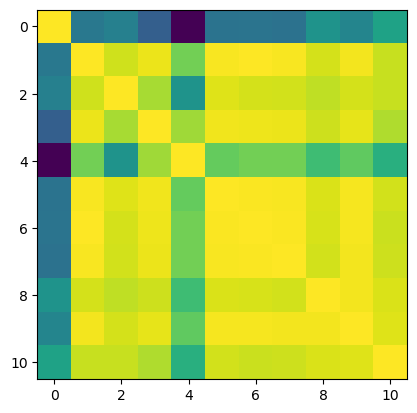

In [296]:
MergeDF_Corr = merged_df[merged_df.columns[2:]].corr(method = 'pearson')
plt.imshow(MergeDF_Corr)

In [297]:
MergeDF_Corr.sort_values("Deaths",ascending= False, inplace = True)
print(MergeDF_Corr.Deaths.head(20))

Deaths                          1.000000
Absolute_No_Activity            0.848163
Absolute_Obese                  0.826916
Absolute_Overweight_or_Obese    0.805824
sub_75k_income                  0.799151
Population                      0.786109
Female_Population               0.780631
Total                           0.779018
Absolute_Overweight             0.776854
between_75k_150k_income         0.750464
above_150k_income               0.642940
Name: Deaths, dtype: float64


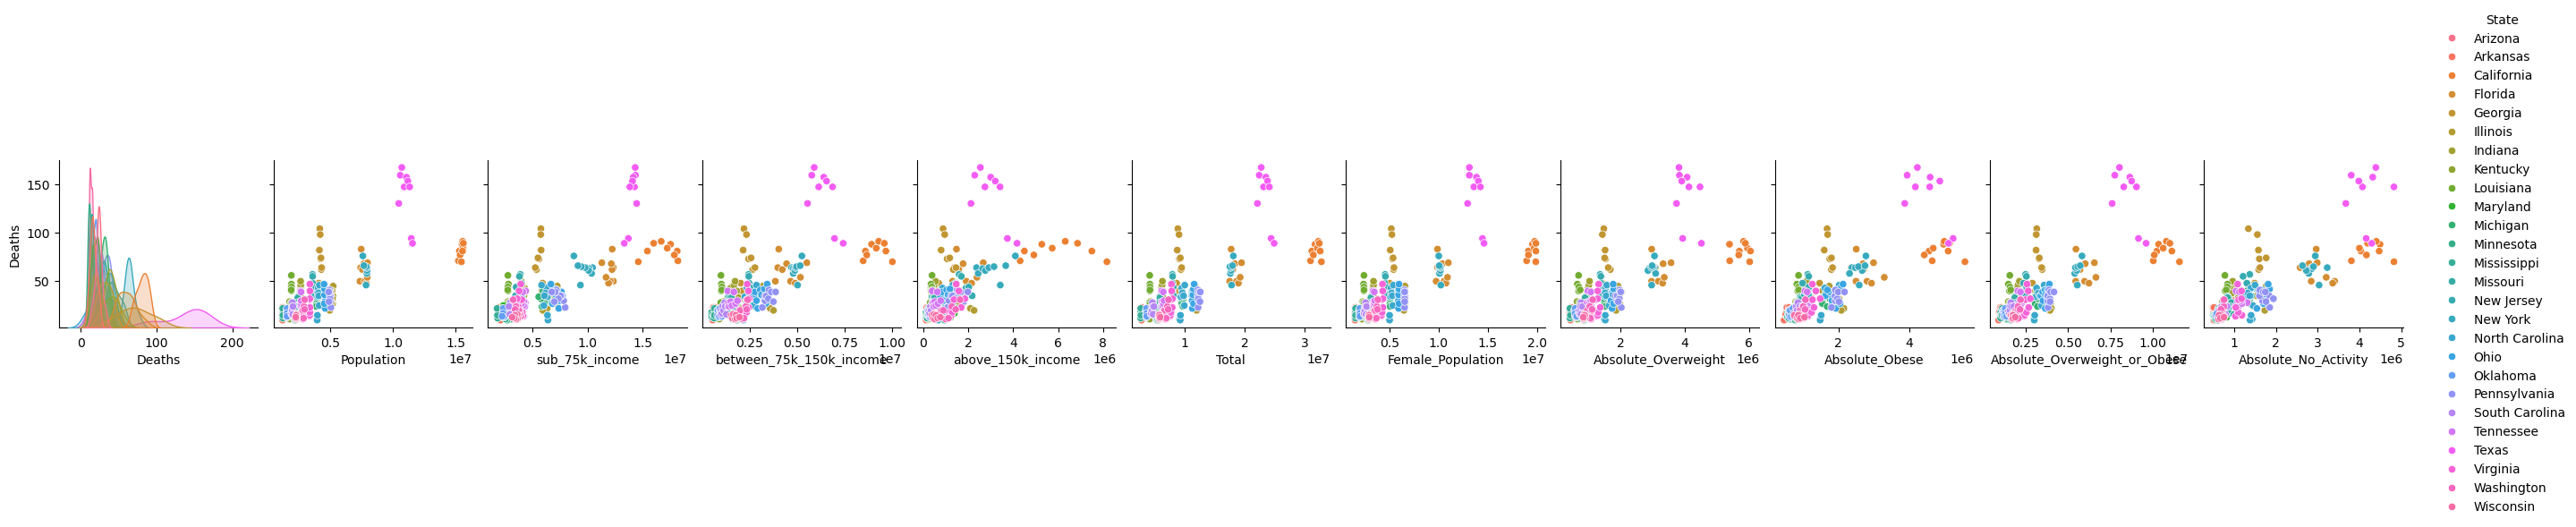

In [298]:
merged_good = merged_df[merged_df.State.isin(list(merged_df.groupby("State").Year.count().reset_index()[merged_df.groupby("State").Year.count().reset_index().Year>=7].State.unique()))]
sns.pairplot(merged_good, hue = "State", y_vars= 'Deaths', x_vars = merged_good.columns[2:])

In [299]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.linear_model import Lasso, LinearRegression, PoissonRegressor, Ridge
from sklearn.feature_selection import RFE, RFECV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [300]:
merged_good.head()
y = merged_good.Deaths.values
X = merged_good[merged_good.columns[3:]].values
X_train, X_test , y_train, y_test = train_test_split(X,y, shuffle= True, test_size = .2, random_state= 12)
numerical_columns = merged_good.columns[3:]


#### Merged Data for Scaled Data
```merged_df[Maternal_Mortality_Rate]``` will be $\displaystyle \frac{\# \textup{Maternal Deaths}}{\textup{Births}} \times 100,000.$


The income categories are scaled by the ```Total``` index which is the total population of the state.

This doesn't inlcude any ```natality_df``` dataframe information, but that can be incorporated easily. I  just don't know that data as well.

,State,Year,Births,BirthCenterBirths,MD_Delivery,DO_Delivery,CNM_Delivery,Other_Delivery_Attendant,Unmarried,3rdMonthInitialCare,4thMonthInitialCare,7thMonthInitialCare,8thMonthInitialCare,UnknownInitialCare,20-27Weeks,32-35Weeks,37-39Weeks,40Weeks,42PlusWeeks
0,Arizona,2010,87477,437,72469,8937.0,5249,177,39294,0,0,0,0,0,465,3579,55528,18468,337
1,Arizona,2011,85543,454,71480,8295.0,4825,178,38227,0,0,0,0,0,546,3421,54646,18076,321
2,Arizona,2012,86441,505,71309,8526.0,5617,199,39319,0,0,0,0,0,480,3476,55425,18265,271
3,Arizona,2013,85600,459,70436,8545.0,5568,235,38875,0,0,0,0,0,437,3430,54667,18067,261
4,Arizona,2014,86887,511,71286,9011.0,6252,238,39224,20467,8059,2258,1730,1627,474,3440,55382,17920,290


In [18]:
scale_income = copy.copy(income_df)
for c in scale_income.columns:
    if not c in ["State","Year","Total"]:
        scale_income[c] = scale_income[c]/scale_income.Total
scale_income = scale_income[scale_income.columns[:-1]]


merged_df = pd.merge(left = maternal_mortality_df, right = scale_income, on = ["Year","State"], how = 'inner')
print(f"Maternal mortality and income data frame has size {merged_df.shape}.")
merged_df = pd.merge(left = merged_df, right = behavior_df[[c for c in behavior_df.columns if not "Absolute" in c]], on =["Year", "State"], how = 'inner' )
print(f'Maternal mortality, income, and behavioral data frame has size {merged_df.shape}')
merged_df = pd.merge(left = merged_df, right = natility_df, on =["Year", "State"], how = 'inner' )
print(f'Maternal mortality, income, and behavioral data frame has size {merged_df.shape}')

merged_df["Maternal_Mortality_Rate"] = merged_df.Deaths/merged_df.Births*(10**5)
for c in natility_df.columns[3:]:
    merged_df[c] = merged_df[c]/merged_df.Births
    

### Change Column Order
all_column_list = list(merged_df.columns)
all_column_list.remove("Female_Population")
all_column_list.remove("Deaths")
all_column_list.remove("Population")
column_list = ["State","Year", "Maternal_Mortality_Rate"]
for c in column_list:
    all_column_list.remove(c)
column_list.extend(all_column_list)

merged_df = merged_df[column_list]
merged_df.head()
merged_df.to_csv("..\\data\\merged_data_sets\\merged_data_scaled_totals.csv", index = False)


Maternal mortality and income data frame has size (293, 14).
Maternal mortality, income, and behavioral data frame has size (267, 19)
Maternal mortality, income, and behavioral data frame has size (134, 36)


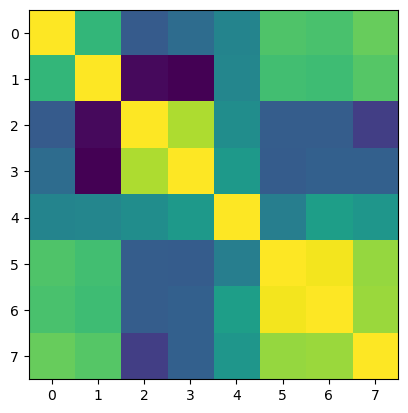

In [292]:
MergeDF_Corr = merged_df[merged_df.columns[2:]].corr(method = 'pearson')
plt.imshow(MergeDF_Corr)


In [293]:
MergeDF_Corr.sort_values("Death_Rate",ascending= False, inplace = True)
print(MergeDF_Corr.Death_Rate.head(20))

Death_Rate                     1.000000
Percent_No_Activity            0.542315
Percent_Obese                  0.459676
Percent_Overweight_or_Obese    0.438087
sub_75k_income                 0.340650
Percent_Overweight            -0.079669
above_150k_income             -0.268725
between_75k_150k_income       -0.396579
Name: Death_Rate, dtype: float64


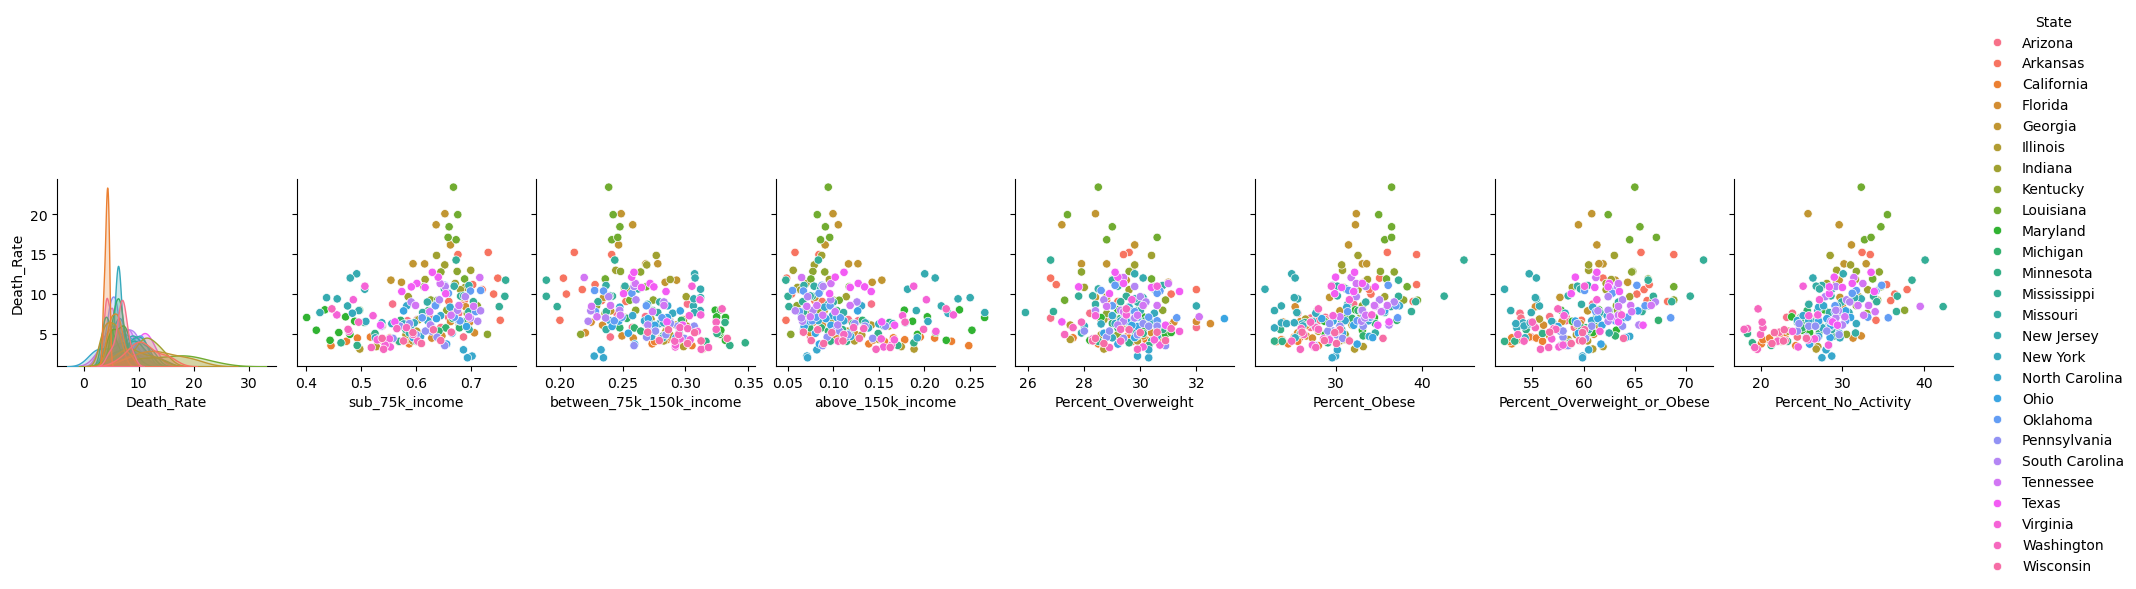

In [294]:
merged_good = merged_df[merged_df.State.isin(list(merged_df.groupby("State").Year.count().reset_index()[merged_df.groupby("State").Year.count().reset_index().Year>=7].State.unique()))]
sns.pairplot(merged_good, hue = "State", y_vars= 'Death_Rate', x_vars = merged_good.columns[2:])